In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

#mcc implementation
from torchmetrics.classification import MultilabelMatthewsCorrCoef

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_transforms = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=train_transforms)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 291):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [5]:
net = ResNet(ResidualBlock, [4, 3, 2, 1]).to(device)
net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [6]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

test_acc = []

mcc_list = []

lrs = []
steps = []

epoch_affichage = 1

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 76)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    """
    print("predicted = ",predicted)
    print("labels = ",labels)
    """
    
    #MCC implementation
    """
    metric_mcc = MultilabelMatthewsCorrCoef(num_labels=291)
    metric_mcc(predicted, labels)
    mcc_list.append(metric_mcc)
    """
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 75: # a changer si besoin d'afficher la matrice de confusion, a mettre à epoch-1
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

    with torch.no_grad():
        correct_t = 0
        total_t = 0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
            
            running_acc_t = correct_t / total_t
        test_acc.append(running_acc_t)
    
        if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
            print('Accuracy of the network on test images: %d %%' % (100 * correct_t / total_t))

print('Finished Training')

  0%|          | 0/76 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 22.042% | Train Loss => 3.54642
validation Acc.  => 40.387% | validation Loss  => 2.37577
Accuracy of the network on test images: 39 %

Epoch: 1
Train Acc. => 49.110% | Train Loss => 1.95560
validation Acc.  => 56.597% | validation Loss  => 1.58789
Accuracy of the network on test images: 56 %

Epoch: 2
Train Acc. => 62.230% | Train Loss => 1.37878
validation Acc.  => 66.097% | validation Loss  => 1.22143
Accuracy of the network on test images: 66 %

Epoch: 3
Train Acc. => 69.548% | Train Loss => 1.08248
validation Acc.  => 71.242% | validation Loss  => 1.00904
Accuracy of the network on test images: 71 %

Epoch: 4
Train Acc. => 74.425% | Train Loss => 0.88989
validation Acc.  => 74.548% | validation Loss  => 0.88166
Accuracy of the network on test images: 75 %

Epoch: 5
Train Acc. => 78.110% | Train Loss => 0.75758
validation Acc.  => 78.000% | validation Loss  => 0.75820
Accuracy of the network on test images: 76 %

Epoch: 6
Train Acc. => 80.727% | Train Loss =

validation Acc.  => 91.742% | validation Loss  => 0.30110
Accuracy of the network on test images: 91 %

Epoch: 52
Train Acc. => 98.364% | Train Loss => 0.05507
validation Acc.  => 91.339% | validation Loss  => 0.32115
Accuracy of the network on test images: 90 %

Epoch: 53
Train Acc. => 98.390% | Train Loss => 0.05508
validation Acc.  => 91.726% | validation Loss  => 0.29852
Accuracy of the network on test images: 92 %

Epoch: 54
Train Acc. => 98.588% | Train Loss => 0.04852
validation Acc.  => 92.468% | validation Loss  => 0.26682
Accuracy of the network on test images: 92 %

Epoch: 55
Train Acc. => 98.509% | Train Loss => 0.04879
validation Acc.  => 91.468% | validation Loss  => 0.30972
Accuracy of the network on test images: 92 %

Epoch: 56
Train Acc. => 98.649% | Train Loss => 0.04521
validation Acc.  => 92.210% | validation Loss  => 0.28978
Accuracy of the network on test images: 92 %

Epoch: 57
Train Acc. => 98.570% | Train Loss => 0.04722
validation Acc.  => 92.226% | validation

## Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

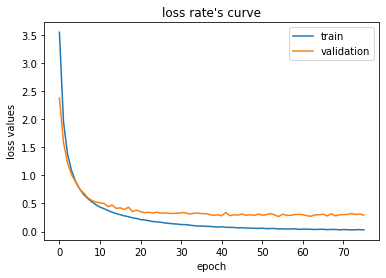

In [9]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

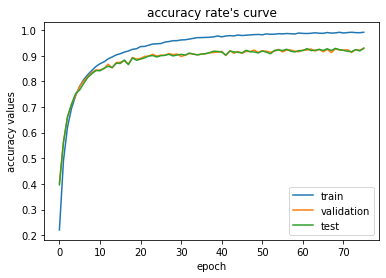

In [10]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [11]:
#plt.plot(mcc_list, label='MCC')
#plt.xlabel("epoch")
#plt.ylabel("MCC values")
#plt.title("MCC curve")
#plt.legend()
#plt.show()

In [12]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[18  0  0 ...  0  0  0]
 [ 1 51  0 ...  0  0  0]
 [ 0  0 23 ...  0  0  0]
 ...
 [ 0  0  0 ... 23  0  0]
 [ 0  0  0 ...  0 24  0]
 [ 0  0  0 ...  0  0 39]]


<AxesSubplot:>

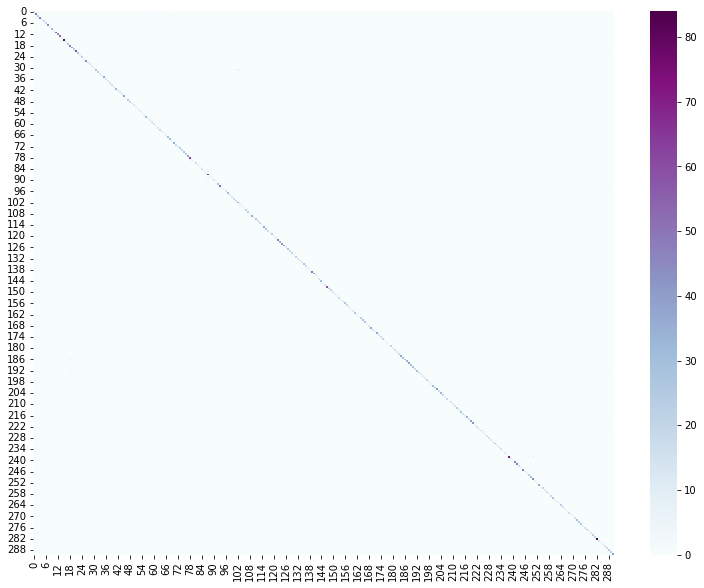

In [13]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [14]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 90.          86.44067797  95.83333333  89.47368421  87.5
 100.          90.90909091  97.87234043 100.          86.84210526
  90.         100.          95.74468085  98.21428571  88.88888889
  95.34883721 100.          96.15384615  92.45283019  88.63636364
  88.46153846  89.70588235  90.32258065 100.          91.66666667
 100.          97.87234043 100.          92.85714286 100.
 100.          79.41176471  91.66666667 100.         100.
 100.          86.66666667 100.          93.75        88.88888889
  90.90909091  91.66666667  94.44444444  87.5         92.85714286
 100.         100.          89.28571429  86.95652174  91.66666667
 100.         100.          87.5         90.90909091 100.
  90.90909091  93.93939394  56.          81.81818182 100.
  88.23529412 100.         100.          86.36363636  92.85714286
  55.55555556  83.33333333  88.23529412 100.          83.33333333
 100.          95.          95.         100.         100.
  96.42857143  95.83333333  95.         100.          81.

## Save

In [15]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [16]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [17]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [18]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"